## Exploratory Analysis

The goal is to discover features that may have predictive power to target variables (i.e. sales) through visualizing their historical pattern.

Areas of focus:

* Are there seasonal pattern on sales in toy industry in general?
* Would the day of the week (e.g. Monday vs Friday) be consistently different?
* Would sales be influenced by public holidays such as Christmas?
* Would there be certain products that dominate sales volumes and hence play a bigger role on sales prediction?
* Would there be obvious product life cycle (growth, mature, decline) that would help to determine future sales?
* Would there be shops that a bigger share in total sales? Would shops that behaves similarly that can be grouped together for analysis?

Import libraries and will read off 'data/train_df.csv' as the starting point.
Since we want to check if major holidays may impact sales, an additional package 'holidays' is needed. Uncomment the pip install code below to obtain the package.

In [1]:
# !pip install holidays

In [3]:
from datetime import date
from datetime import datetime as dt

import holidays
import matplotlib.pyplot as plt
# from translate import Translator as tran
# from googletrans import Translator as googtran
import numpy as np
import pandas as pd
import seaborn as sns

sns.set()
%matplotlib inline

C:\Users\sit_k\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
train_df = pd.read_csv('data/train_df.csv', parse_dates=['date'])

In [5]:
train_df.columns

Index(['date', 'date_block_num', 'shop_id', 'shop_name', 'item_id',
       'item_name', 'item_category_id', 'item_category_name', 'item_price',
       'item_cnt_day', 'sales'],
      dtype='object')

#### Assess Seasonality 

In [6]:
# To identify seasonal pattern, leverage date_block_num and groupby sales
seasonal = train_df.groupby(['date_block_num'])['sales'].sum()
seasonal = seasonal.reset_index(drop=False)

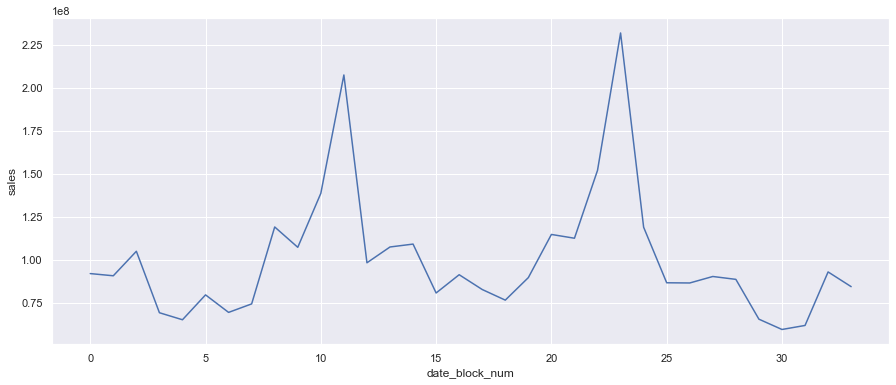

In [7]:
plt.figure(figsize=(15, 6))
sns.lineplot(x='date_block_num', y='sales', data=seasonal)
plt.show()

There is a clear recurring peak pattern at date_block_num at 12 and 24, which translate to Dec 2013 and Dec 2014. Overall annually sales pattern seem to repeat itself. We have strong reason to believe that month itself will be a predictive feature for sales

#### Assess day of week impact to sales

In [8]:
# weekDays = ("Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday")
weekday = train_df.groupby(['date'])['sales'].sum().reset_index(drop=False)

In [9]:
weekday['dayofweek'] = weekday['date'].dt.day_name()

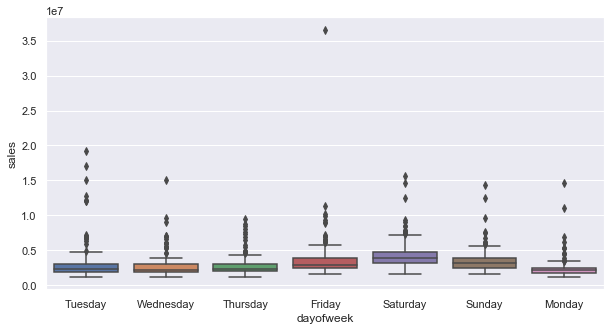

In [10]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='dayofweek', y='sales', data=weekday)
plt.show()

Friday, Saturday, and Sunday tend to have higher sales. Though each day seem to have a wide range of outliers. Will test this features later

In [11]:
outlier_date = weekday.query('dayofweek == "Friday"')
outlier_date.sort_values('sales', ascending=False).head()

,date,sales,dayofweek
332,2013-11-29,3.654481e+07,Friday
633,2014-09-26,1.136100e+07,Friday
724,2014-12-26,1.012983e+07,Friday
717,2014-12-19,9.887526e+06,Friday
360,2013-12-27,9.359054e+06,Friday


The most extreme outlier is on Friday (2013-11-29). Separate research will be done to determine on handling method.

#### Assess National Holiday impact to sales

In [12]:
# create an empty dictionary that will hold all the national holiday
holiday = {}

In [13]:
for date, name in sorted(holidays.RU(years=[2013, 2014, 2015]).items()):

    holiday[date] = name

In [14]:
# Below is the set of the national holiday in Russia
set(holiday.values())

{'День Победы',
 'День России',
 'День женщин',
 'День защитника отечества',
 'День народного единства',
 'Новый год',
 'Православное Рождество',
 'Праздник Весны и Труда'}

In [15]:
# Add a new column to capture the holiday. Days that don't have a holiday match will be call 'Norm'
weekday['holiday'] = weekday['date'].apply(
    lambda x: x.date()).map(holiday).fillna('Norm')

In [16]:
weekday.head()

,date,sales,dayofweek,holiday
0,2013-01-01,1362942.00,Tuesday,Новый год
1,2013-01-02,6020512.03,Wednesday,Новый год
2,2013-01-03,5436480.11,Thursday,Новый год
3,2013-01-04,4755664.00,Friday,Новый год
4,2013-01-05,4587231.00,Saturday,Новый год


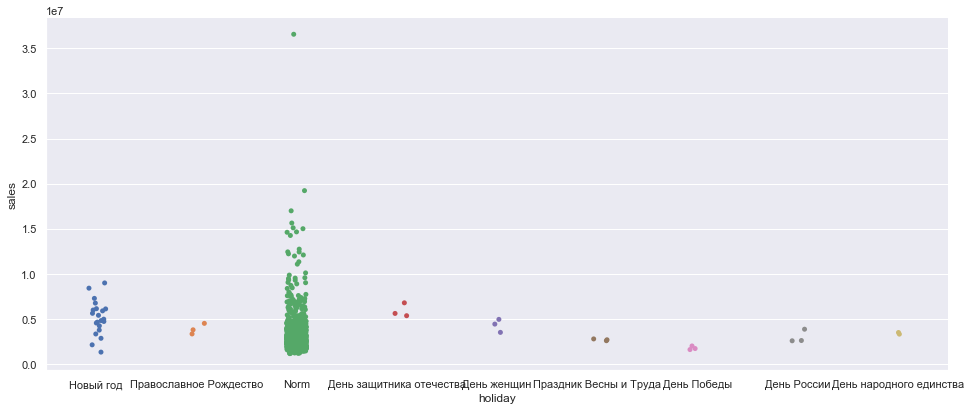

In [17]:
_ = sns.catplot(x='holiday', y='sales', data=weekday, hue='holiday')
_.fig.set_figwidth(18)
_.fig.set_figheight(6)
plt.show()

There isn't a clear trend on suggesting that major holidays will meaningfully impact sales given the sales range.

#### Assess product category

In [18]:
product = train_df.groupby(['item_category_name'])[
    'sales'].sum().reset_index(drop=False)
product = product.sort_values('sales', ascending=False)
# Translate item category from Russian to English
# product['item_category_name'] = product['item_category_name'].apply(lambda x: translator.translate(x))

In [19]:
product.head(15)

,item_category_name,sales
19,Игры - PS3,4.120503e+08
20,Игры - PS4,3.730103e+08
12,Игровые консоли - PS4,2.922398e+08
23,Игры - XBOX 360,2.596191e+08
30,Игры PC - Стандартные издания,2.575193e+08
40,Кино - DVD,1.699442e+08
28,Игры PC - Дополнительные издания,1.364191e+08
55,Музыка - CD локального производства,1.000226e+08
37,Кино - Blu-Ray,9.047873e+07
75,Программы - Для дома и офиса,8.708593e+07


From the clean_wrangling work, we know that there are a total of 84 item categories, which would be too much to visualize one by one and may be too details to identify any trends.
By observing the product snapshop above, it appears that there is higher level of product cateogory (i.e. Games, Music, Gifts, etc) which could be useful to identify trends

In [20]:
# split the item_category once baesd on the first delimiter '-' from the left
product[['sub_cat', 'prod_name']] = product['item_category_name'].str.split(
    '-', n=1, expand=True)

In [21]:
# This step is to further remove potential duplicates on sub_cat
product['sub_cat'] = product['sub_cat'].apply(lambda x: x.strip().lower())

In [22]:
product.head()

,item_category_name,sales,sub_cat,prod_name
19,Игры - PS3,4.120503e+08,игры,PS3
20,Игры - PS4,3.730103e+08,игры,PS4
12,Игровые консоли - PS4,2.922398e+08,игровые консоли,PS4
23,Игры - XBOX 360,2.596191e+08,игры,XBOX 360
30,Игры PC - Стандартные издания,2.575193e+08,игры pc,Стандартные издания


In [23]:
# The following steps are to identify key sales drive by sub_cat level
subcat = product.groupby('sub_cat')['sales'].sum().reset_index(drop=False)
# Adding column for % sales to total by sub_cat
subcat['%'] = ((subcat['sales'] / subcat['sales'].sum())*100).round(2)
subcat = subcat.sort_values('sales', ascending=False).reset_index(drop=True)

In [24]:
subcat  # sub cat will be abbrivation of sub category for the rest the analysis

,sub_cat,sales,%
0,игры,1.153847e+09,33.95
1,игровые консоли,5.280281e+08,15.54
2,игры pc,4.779817e+08,14.06
3,кино,3.349880e+08,9.86
4,подарки,3.091466e+08,9.10
5,аксессуары,1.663868e+08,4.90
6,музыка,1.497200e+08,4.40
7,программы,1.223909e+08,3.60
8,карты оплаты,6.624700e+07,1.95
9,книги,3.034890e+07,0.89


In [25]:
subcat.loc[0:6]['%'].sum()

91.81

In [30]:
subcat['sub_cat'].values

array(['игры', 'игровые консоли', 'игры pc', 'кино', 'подарки',
       'аксессуары', 'музыка', 'программы', 'карты оплаты', 'книги',
       'служебные', 'билеты (цифра)', 'карты оплаты (кино, музыка, игры)',
       'доставка товара', 'элементы питания', 'чистые носители (штучные)',
       'чистые носители (шпиль)', 'игры android', 'игры mac', 'pc'],
      dtype=object)

While there are 19 sub_cat, top 7 drove 90% of the company total revenue. We will make the assumption that any categories below top 8 won't have significant impact to the analysis and will be ignored.

In [26]:
top_cat = subcat.loc[0:6]['sub_cat'].tolist()

Knowing the important sales categories, we want to look into the time series sales for those and identify potential pattern (if any). We want to see of certain categories are uptrending or declining, or if the seasonality driven by a particular categoery. 

In [27]:
# repeat the steps on getting sub_cat features, but this time include time component.
product_top = train_df.groupby(['date_block_num', 'item_category_name'])[
    'sales'].sum().reset_index(drop=False)

In [28]:
# product_top['item_category_name'] = product_top['item_category_name'].apply(lambda x: translator.translate(x))

In [29]:
product_top = pd.merge(product_top, product[[
                       'item_category_name', 'sub_cat']], on='item_category_name', how='left')

In [30]:
product_top = product_top[product_top['sub_cat'].isin(top_cat)]

In [31]:
product_top = product_top.groupby(['date_block_num', 'sub_cat'])[
    'sales'].sum().reset_index(drop=False)

In [32]:
# #translate sub_cat into english for ease of analysis
# product_top['sub_cat'] = product_top['sub_cat'].apply(lambda x: translator_2.translate(x).text)

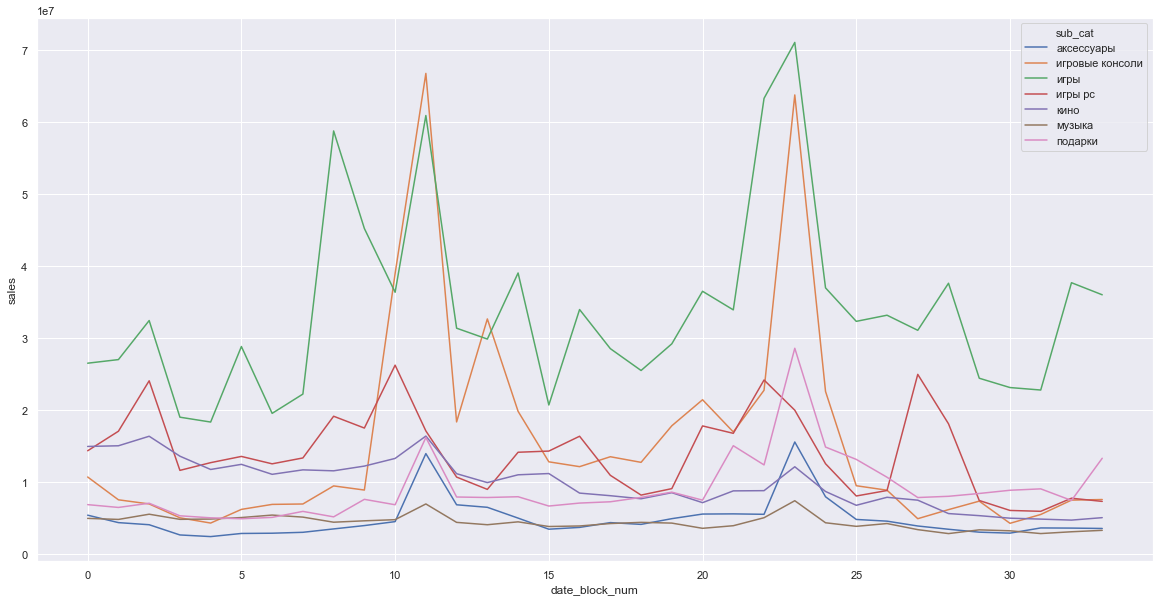

In [33]:
plt.figure(figsize=(20, 10))
sns.lineplot(x='date_block_num', y='sales',
             data=product_top, hue='sub_cat', ci=None)
plt.show()

**Observations**:
* games sub_cat (игры) seem to have more sales spike throughout the year. This is probably the major sales driver for the company, and would tie to the game launch schedule. 
* games pc (игры pc) has some fluctuations but the range is much smaller.
* game consoles ('игровые консоли') sub cat only spike during December and is pretty stable for the rest of the year. That's a good insight as it make forecast for this sub cat easier outside December. The same insight applies to accessories (аксессуары) and gifts (подарки) sub cat
* movie (кино) appear to be a declining sub cat and will need special attention
* aside from small spikes in December, music (музыка) sub cat is mostly flat.

#### Assess Shop

There are 60 shops location in the data set. We want to see if there are top volume stores that drive majority of the revenue and whether annual sales pattern is consistent among shops

In [34]:
shop = train_df.groupby(['shop_name', 'shop_id'])[
    'sales'].sum().reset_index(drop=False)

In [35]:
shop = shop.sort_values('sales', ascending=False).reset_index(drop=True)

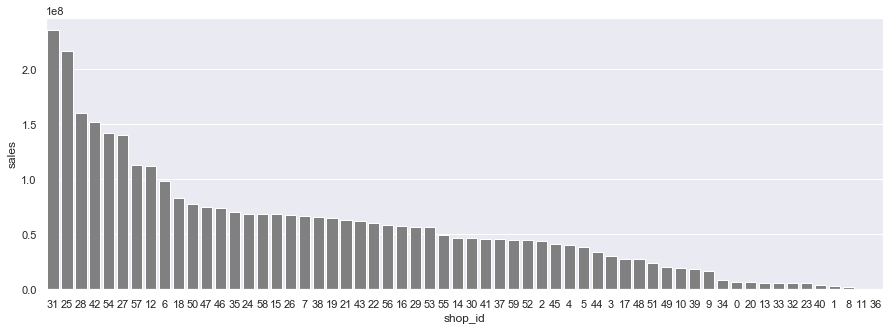

In [36]:
plt.figure(figsize=(15, 5))
_ = sns.barplot(x='shop_id', y='sales', data=shop, ci=None,
                order=shop['shop_id'], color="grey")
plt.show()

Based on visual, there are only 9 store that has total sales of 10M or more. A big range of stores are between 5M-9M range. There are about 1/4 of the stores has small volumes <2M.

We will segment stores into 3 clusters: high (>10M), mid (5M - 10M), low(<5M). We will then look into sales pattern of each groups to understand if there are useful insights.

In [37]:
shop['cluster'] = ''
for i in range(len(shop)):
    if shop['sales'][i] > 100000000:
        shop['cluster'][i] = 'high'
    elif shop['sales'][i] < 100000000 and shop['sales'][i] > 5000000:
        shop['cluster'][i] = 'med'
    else:
        shop['cluster'][i] = 'low'

C:\Users\sit_k\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\sit_k\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\sit_k\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [38]:
# recreate a new dataframe by including the time component for stores
shop_ts = train_df.groupby(['shop_name', 'shop_id', 'date_block_num'])[
    'sales'].sum().reset_index(drop=False)
shop_ts = pd.merge(
    shop_ts, shop[['shop_id', 'cluster']], on='shop_id', how='left')

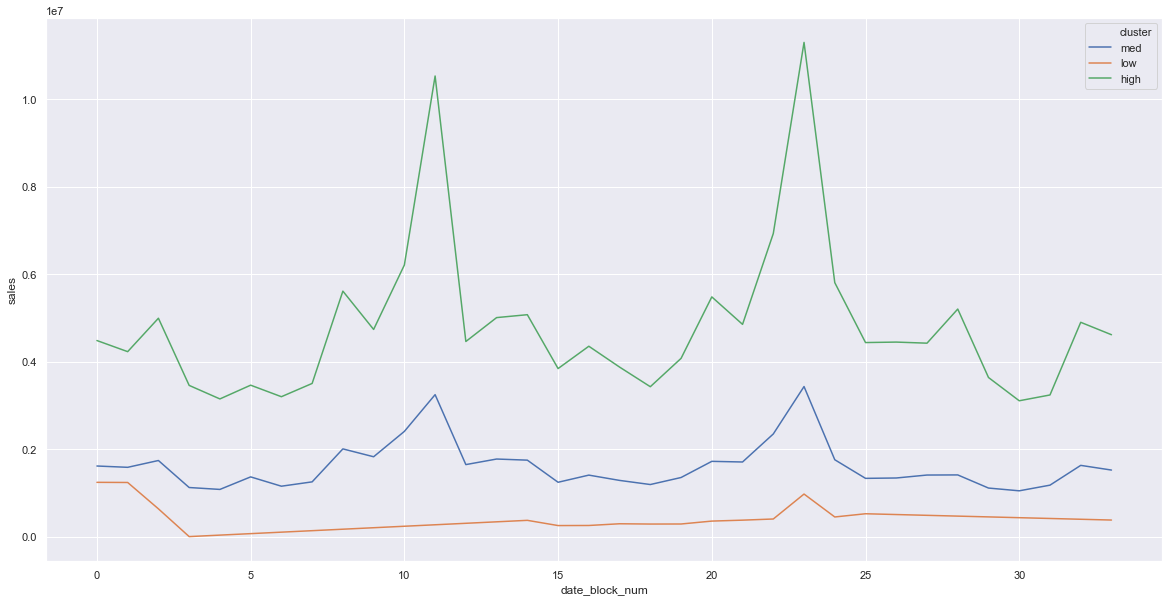

In [39]:
plt.figure(figsize=(20, 10))
sns.lineplot(x='date_block_num', y='sales',
             data=shop_ts, hue='cluster', ci=None)
plt.show()

**Observations**
* both med and high volume stores share simliar seasonality
* low volume stores in general has constant but slighly positive sale pattern

### Summary

* Month appear to be a strong predictive features
* Friday, Saturday, and Sunday appear to have higher sales on average.
* National holidays do not have strong influence on sales
* Product category 'games, games pc' should be forecast separately due to their volatilities. 'games console, accessories, gift' share similar pattern with game console spike more during December. 'music' category is flat while 'movie' category is declining.
* Seasonal sales fluctuations happens more at stores that has sales volume 5M or above. Stores <5M then to have stable (but slightly increasing) sales pattern.